In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from conditionalconformal import CondConf
import random
from scipy.spatial import ConvexHull

In [2]:
def add_average(train_df):
    # Create a copy of train_df
    train_df = train_df.copy()

    # Create a new column with initial value of 0
    train_df['mean_bid'] = 0
    
    # Calculate the average BidAmount for each Bidder and update the mean_bid column
    for bidder in train_df['Bidder'].unique():
        mean_bid = train_df.loc[train_df['Bidder'] == bidder, 'BidAmount'].mean()
        train_df.loc[train_df['Bidder'] == bidder, 'mean_bid'] = mean_bid

    return train_df


In [3]:
# Read the CSV file
Table_palm7 = pd.read_csv("Palm+7-day+149auctions+Curve+Clustering.csv")

# Filter the DataFrame
Table = Table_palm7[(Table_palm7['Seller'] == "syschannel") | (Table_palm7['Seller'] == "michael-33") | (Table_palm7['Seller'] == "saveking")]

# Initializes a Boolean sequence of False values for each row
false = pd.Series([False] * len(Table), index=Table.index)

# Loop through unique Auction.ID and Bidder
for j in Table['Auction ID'].unique():
    for i in Table[Table['Auction ID'] == j]['Bidder'].unique():
        max_bid = Table[(Table['Auction ID'] == j) & (Table['Bidder'] == i)]['BidAmount'].max()
        false |= ((Table['Auction ID'] == j) & (Table['Bidder'] == i) & (Table['BidAmount'] == max_bid))

# Create a new filtered DataFrame
Table_new = Table[false]


In [4]:
Table_new = add_average(Table_new)


Table_new['Rank'] = Table_new.groupby('Auction ID')['BidAmount'].rank(method='dense', ascending=False)
Table_true = Table_new[Table_new['Rank'] > 1]
Table_new.drop(columns=['Rank'], inplace=True) 
Table_true= Table_true.copy()
Table_true.drop(columns=['Rank'], inplace=True) 

Table_new = Table_true


In [5]:
syschannel_count = len(Table_new[Table_new['Seller'] == 'syschannel'])
michael_count = len(Table_new[Table_new['Seller'] == 'michael-33'])
saveking_count = len(Table_new[Table_new['Seller'] == 'saveking'])

average_bidders = 0
for auction_id in Table_new['Auction ID'].unique():
    average_bidders += len(Table_new[Table_new['Auction ID'] == auction_id])

average_bidders /= len(Table_new['Auction ID'].unique())

print(f"Average bidders: {average_bidders}")

Average bidders: 12.318181818181818


In [6]:

# Get unique Auction.ID for each Seller
Seller_syschannel = Table_new[Table_new['Seller'] == "syschannel"]['Auction ID'].unique()
Seller_michael = Table_new[Table_new['Seller'] == "michael-33"]['Auction ID'].unique()
Seller_saveking = Table_new[Table_new['Seller'] == "saveking"]['Auction ID'].unique()

# Create a list of DataFrames
Table_his_syschannel = []
Table_new_syschannel = []
for i in Seller_syschannel:
    Table_his_syschannel.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_syschannel.append(Table_new[Table_new['Auction ID'] == i])
    
Table_his_michael = []
Table_new_michael = []
for i in Seller_michael:
    Table_his_michael.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_michael.append(Table_new[Table_new['Auction ID'] == i])

Table_his_saveking = []
Table_new_saveking = []
for i in Seller_saveking:
    Table_his_saveking.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_saveking.append(Table_new[Table_new['Auction ID'] == i])



In [7]:
def find_remaining_numbers(original_numbers, selected_numbers):
    remaining_numbers = [num for num in original_numbers if num not in selected_numbers]
    return remaining_numbers


def split(Table):
    Table = Table.reset_index(drop=True)
    train_df = pd.DataFrame(columns=Table.columns)
    cali_df = pd.DataFrame(columns=Table.columns)
    N = len(Table)
    half_N = int(N/2)
    selected_numbers = random.sample(list(range(1, N + 1)), half_N)
    train_N = sorted(selected_numbers)
    cali_N = find_remaining_numbers(list(range(1, N + 1)),train_N)
    cali_N = [x - 1 for x in cali_N ]
    train_N = [x - 1 for x in train_N]
    train_df = Table.loc[train_N]
    cali_df = Table.loc[cali_N]

    return train_df, cali_df


In [8]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,3])

    # Initialize the indicator matrix
    matrix = np.zeros((len(scalar_values), 3))
    value_z = np.array(["syschannel","michael-33","saveking"])

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0,3):
            if  value == value_z[j]:
                matrix[i, j] = 1

    return matrix

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=2), ['x1', 'x2', 'x3']),  
        ('cat', OneHotEncoder(), ['z'])
    ])


In [9]:
def delete_none(train_df, new_df):

    unique_bidders = train_df['Bidder'].unique()
    
    new = new_df[new_df['Bidder'].isin(unique_bidders)]

    return new

In [10]:
def create_coordinates(v):
    m = len(v)
    coordinates = np.zeros((m, 2))  
    for j in range(m):
        coordinates[j, 0] = (2 * j + 1) / (2 * m) 
        coordinates[j, 1] = (2 * j + 1) * v[j] / (2 * m)  
    return coordinates

def get_slope(x, hull_points, slopes):
    for i in range(len(hull_points) - 1):
        x1, x2 = hull_points[i][0], hull_points[i + 1][0]
        if x1 <= x <= x2:
            if x == x2 and i < len(slopes) - 1:
                return max(slopes[i], slopes[i + 1])
            if x == x1 and i > 0:
                return max(slopes[i - 1], slopes[i])
            return slopes[i]
    return None


def find_last_min_non_negative_index(nums):
    min_non_neg = float('inf')  
    min_index = -1  
    for i, num in enumerate(nums):
        if num >= 0 and num <= min_non_neg:
            min_non_neg = num
            min_index = i
    return min_index


def myerson_reserve(Table):
    sorted_bids = np.sort(Table['BidAmount'])[::-1] 
    new_vector_1 = create_coordinates(sorted_bids)
    new_points = np.array([[0, 0], [1, 0]])
    new_vector_1 = np.concatenate((new_points[0:1], new_vector_1, new_points[1:2]), axis=0)
    points = new_vector_1
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = hull_points[hull_points[:, 0].argsort()]
    slopes = []
    for i in range(len(hull_points) - 1):
        x1, y1 = hull_points[i]
        x2, y2 = hull_points[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)
    point_slopes = []
    for point in points:
        x = point[0]
        slope = get_slope(x, hull_points, slopes)
        point_slopes.append(slope)
    index_reserve = find_last_min_non_negative_index(point_slopes[1:-1])
    return sorted_bids[index_reserve]


In [11]:
def change_N_N(Table_old,Table_new,N=800,item="syschannel"):
    IR = []
    Pay = []
    new_data_2nd = []
    welfare = []
    new_data_myerson = []
    Myerson_Reserve_Price = []
    for i in range(0,len(Table_old)):
        df_his = Table_old[i]
        df_his = df_his.sample(n=N)
        
        ################ The Empirical Myerson Auction
        df_myerson = df_his[df_his['Seller'] == item]
        myerson_reserve_price = myerson_reserve(df_myerson)
        Myerson_Reserve_Price.append(myerson_reserve_price)
        ################
        
        D_train = split(df_his)[0]
        D_cali = split(df_his)[1]
        
        Condition_data = delete_none(Table_old[i], Table_new[i])
        D_train = pd.DataFrame({'x1': D_train['BidTime'],'x2': D_train['mean_bid'], 'x3': D_train['Bidder Rating'], 'y': D_train['BidAmount'], 'z': D_train['Seller']})
        D_cali = pd.DataFrame({'x1': D_cali['BidTime'],'x2': D_cali['mean_bid'], 'x3': D_cali['Bidder Rating'], 'y': D_cali['BidAmount'], 'z': D_cali['Seller']})
        X = D_train[['x1', 'x2', 'x3', 'z']]
        y = D_train['y']
        model = make_pipeline(preprocessor, LinearRegression())
        model.fit(X, y)
        D_new = pd.DataFrame({'x1': Condition_data['BidTime'], 'x2': Condition_data['mean_bid'],'x3': Condition_data['Bidder Rating'],'y': Condition_data['BidAmount'], 'z': Condition_data['Seller']})
        X_new = D_new[['x1', 'x2', 'x3','z']]
        y_new = D_new['y']
        new_data = pd.DataFrame({'x1': D_new['x1'],'x2': D_new['x2'], 'x3': D_new['x3'],'z': D_new['z'], 'y': D_new['y']})
        y_new_predict = model.predict(X_new)
        score_fn = lambda feature,  y : abs(y - model.predict(pd.DataFrame({'x1': feature[:,0],'x2': feature[:,1],'x3': feature[:,2], 'z': feature[:,3]})))
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(D_cali[['x1', 'x2', 'x3', 'z']].to_numpy(),D_cali['y'].to_numpy())
        alpha = 0.1
        Xtest = np.array([new_data[['x1', 'x2', 'x3', 'z']].to_numpy()[0,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        hat_t_L = y_new_predict - d 
        hat_t_U = y_new_predict + d 
        IR.append(np.mean((hat_t_L <= new_data['y']) & (new_data['y'] <= hat_t_U)))
    
        reserve_price = hat_t_L
        virtual_value = new_data['y'] * (new_data['y'] > reserve_price)

        # Find the index(es) of the maximum virtual value
        max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]

        winner = None
        if len(max_virtual_value_indexes) > 1:
        # Check the reserve price for the max virtual value indexes
            max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

            if len(max_reserve_price_indexes) > 1:
            # If multiple maximums, choose one at random
                winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
            else:
            # If only one maximum
                winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
        else:
        # If only one maximum virtual value
            winner = max_virtual_value_indexes[0]

        sorted_virtual_value = np.sort(virtual_value)[::-1]


        sorted_virtual_value_2 = sorted_virtual_value[1] if len(sorted_virtual_value) >= 2 else 0

        payment = max(0, sorted_virtual_value_2, reserve_price[winner],Condition_data['Opening Bid'].iloc[0])
        max_welfare = np.max(new_data['y'])
        welfare.append(max_welfare)
        Pay.append(payment)

        new_data_2 = np.sort(new_data['y'])[::-1][1] if len(np.sort(new_data['y'])[::-1]) >= 2 else Condition_data['Opening Bid'].iloc[0]
        new_data_2nd.append(new_data_2)
        
        new_data_m = np.maximum(np.sort(new_data['y'])[::-1][1], myerson_reserve_price) if np.sort(new_data['y'])[::-1][0] >= myerson_reserve_price else Condition_data['Opening Bid'].iloc[0]
        new_data_myerson.append(new_data_m)
        

    return Pay, new_data_myerson, new_data_2nd, welfare,  IR, Myerson_Reserve_Price

In [12]:
def repeated_exp(Table_old, Table_new, N=700, item="syschannel", num_runs=2):
    l = len(Table_new)

    COAD_matrix = np.zeros((num_runs, l))
    myerson_revenue_matrix = np.zeros((num_runs, l))
    second_price_matrix = np.zeros((num_runs, l))
    max_welfares_matrix = np.zeros((num_runs, l))
    coverage_matrix = np.zeros((num_runs, l))
    Reserve_matrix = np.zeros((num_runs, l))

    for i in range(num_runs):
        Pay, new_data_myerson, new_data_2nd, welfare, IR, Reserve_Price = change_N_N(Table_old, Table_new, N, item)
        COAD_matrix[i, :] = Pay
        myerson_revenue_matrix[i, :] = new_data_myerson
        second_price_matrix[i, :] = new_data_2nd
        max_welfares_matrix[i, :] = welfare
        coverage_matrix[i, :] = IR
        Reserve_matrix[i, :] = Reserve_Price

    second_price = np.mean(second_price_matrix, axis=0)
    max_welfares = np.mean(max_welfares_matrix, axis=0)
    Reserve = np.mean(Reserve_matrix, axis=0)
    return COAD_matrix, myerson_revenue_matrix, second_price, max_welfares, coverage_matrix, Reserve  

def auction_index(vector):
    return [i for i, x in enumerate(vector) if x > 0]

def get_CI(data):
    lower_percentile = np.mean(data)- 1.96*np.std(data)/np.sqrt(len(data))
    upper_percentile = np.mean(data)+ 1.96*np.std(data)/np.sqrt(len(data))
    return lower_percentile, upper_percentile


In [13]:
def diff_N(Table_his, Table_new,N=500,item="syschannel",num_runs=10, indices=[0]):
    COAD_matrix, myerson_revenue_matrix, second_price, max_welfares, coverage_matrix, Reserve = repeated_exp(Table_his, Table_new,N,item,num_runs)
    COAD_matrix = COAD_matrix[:, indices]
    myerson_revenue_matrix = myerson_revenue_matrix[:, indices]
    second_price = [second_price[i] for i in indices]
    max_welfares = [max_welfares[i] for i in indices]
    coverage_matrix = coverage_matrix[:, indices]
    Reserve = [Reserve[i] for i in indices]
    
    COAD = np.mean(COAD_matrix, axis=0)
    myerson_revenue = np.mean(myerson_revenue_matrix, axis=0)

    COAD_average = np.mean(COAD)
    COAD_CI = get_CI(np.mean(COAD_matrix, axis=1))
    myerson_revenue_average = np.mean(myerson_revenue)
    myerson_revenue_CI = get_CI(np.mean(myerson_revenue_matrix, axis=1))
    second_price_average = np.mean(second_price)
    max_welfares_average = np.mean(max_welfares)
    reserve_price = np.mean(Reserve)

    coverage_IR = np.mean(coverage_matrix, axis=1)
    return COAD_average, COAD_CI, myerson_revenue_average, myerson_revenue_CI, second_price_average, max_welfares_average,coverage_IR, reserve_price

    

In [15]:
random.seed(1)
np.random.seed(1)

N_values = [150,300,500,700]

COAD_averages = []
COAD_CIs = []
myerson_revenue_averages = []
myerson_revenue_CIs = []
second_price_averages = []
coverage_IRs = []
reserve_prices = []

for N in N_values:
    Table_his = Table_his_syschannel 
    Table_new = Table_new_syschannel
    item = "syschannel"
    num_runs = 1000
    indices= [0, 1, 2, 14, 15, 17, 21, 25, 27] 
    COAD_average, COAD_CI, myerson_revenue_average, myerson_revenue_CI, second_price_average, _, coverage_IR, reserve_price = diff_N(Table_his, Table_new,N,item,num_runs, indices)
    COAD_averages.append(COAD_average)
    COAD_CIs.append(COAD_CI)
    myerson_revenue_averages.append(myerson_revenue_average)
    myerson_revenue_CIs.append(myerson_revenue_CI)
    second_price_averages.append(second_price_average)
    coverage_IRs.append(coverage_IR)
    reserve_prices.append(reserve_price)

In [16]:
COAD_CIs = [(x[1]-x[0])/2 for x in COAD_CIs]
myerson_revenue_CIs = [(x[1]-x[0])/2 for x in myerson_revenue_CIs]

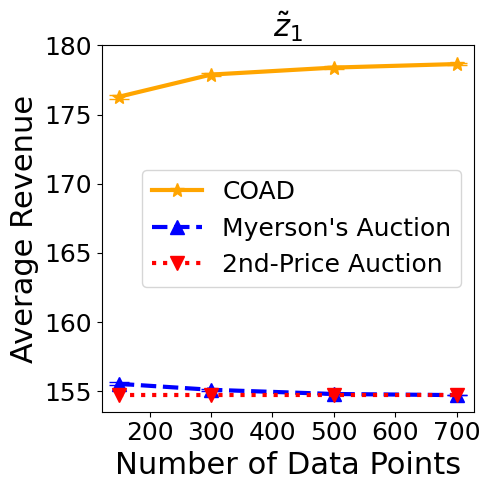

In [19]:
plt.figure(figsize=(5, 5))

plt.plot(N_values, COAD_averages, label="COAD", color='orange', linewidth=3, marker='*', markersize=10)
plt.plot(N_values, myerson_revenue_averages, label="Myerson's Auction", color='blue', linestyle='--', linewidth=3, marker='^', markersize=10)
plt.errorbar(N_values, COAD_averages, yerr=COAD_CIs, fmt='none', ecolor='orange', capsize=7, elinewidth=2)
plt.errorbar(N_values, myerson_revenue_averages, yerr=myerson_revenue_CIs, fmt='none', ecolor='blue', capsize=7, elinewidth=2)
plt.plot(N_values, second_price_averages, label="2nd-Price Auction", color='red', linestyle=':', linewidth=3, marker='v', markersize=10)

plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel("Average Revenue", fontsize=22)
plt.title(r"$\tilde{z}_1$", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks([155,160,165,170,175,180], fontsize=18)
plt.legend(fontsize=18)
plt.grid(False)

plt.tight_layout()
plt.show()

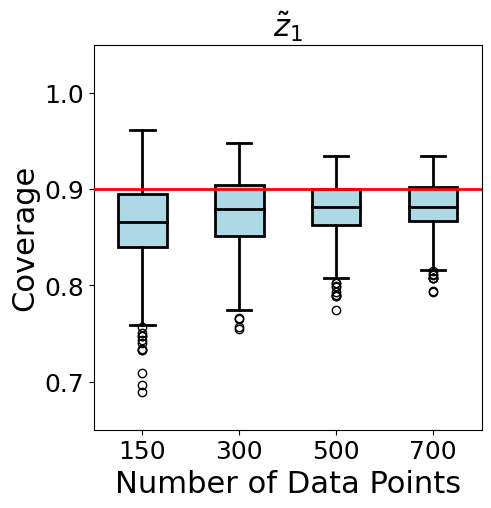

In [589]:
fig = plt.figure(figsize=(5, 5))
plt.boxplot(coverage_IRs, patch_artist=True, 
            medianprops=dict(color="black", linewidth=2),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  
plt.title(r"$\tilde{z}_1$", fontsize=22)
plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel('Coverage', fontsize=22)
plt.locator_params(axis='y', nbins=5)  
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=18)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=18) 
plt.ylim([0.65, 1.05]) 
plt.show()

In [20]:
random.seed(1)
np.random.seed(1)

N_values = [150,300,500,700]

COAD_averages = []
COAD_CIs = []
myerson_revenue_averages = []
myerson_revenue_CIs = []
second_price_averages = []
coverage_IRs = []
reserve_prices = []

for N in N_values:
    Table_his = Table_his_michael
    Table_new = Table_new_michael
    item = "michael-33"
    num_runs = 1000
    indices= [2, 7, 13, 14, 15]
    COAD_average, COAD_CI, myerson_revenue_average, myerson_revenue_CI, second_price_average, _, coverage_IR, reserve_price = diff_N(Table_his, Table_new,N,item,num_runs, indices)
    COAD_averages.append(COAD_average)
    COAD_CIs.append(COAD_CI)
    myerson_revenue_averages.append(myerson_revenue_average)
    myerson_revenue_CIs.append(myerson_revenue_CI)
    second_price_averages.append(second_price_average)
    coverage_IRs.append(coverage_IR)
    reserve_prices.append(reserve_price)

In [21]:
COAD_CIs = [(x[1]-x[0])/2 for x in COAD_CIs]
myerson_revenue_CIs = [(x[1]-x[0])/2 for x in myerson_revenue_CIs]

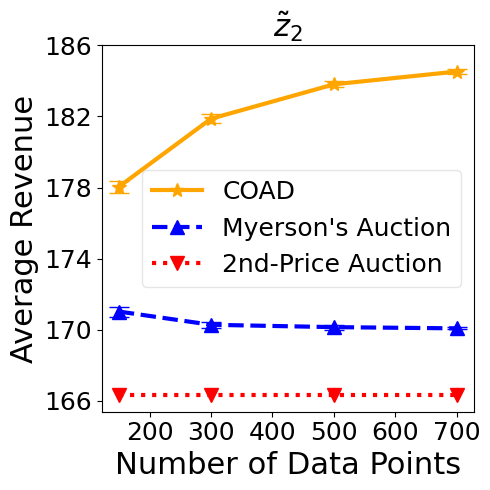

In [23]:
plt.figure(figsize=(5, 5))

plt.plot(N_values, COAD_averages, label="COAD", color='orange', linewidth=3, marker='*', markersize=10)
plt.plot(N_values, myerson_revenue_averages, label="Myerson's Auction", color='blue', linestyle='--', linewidth=3, marker='^', markersize=10)
plt.errorbar(N_values, COAD_averages, yerr=COAD_CIs, fmt='none', ecolor='orange', capsize=7, elinewidth=2)
plt.errorbar(N_values, myerson_revenue_averages, yerr=myerson_revenue_CIs, fmt='none', ecolor='blue', capsize=7, elinewidth=2)
    
plt.plot(N_values, second_price_averages, label="2nd-Price Auction", color='red', linestyle=':', linewidth=3, marker='v', markersize=10)

plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel("Average Revenue", fontsize=22)
plt.title(r"$\tilde{z}_2$", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks([166,170,174,178,182,186], fontsize=18)
plt.legend(fontsize=18,framealpha=0.5)
plt.grid(False)

plt.tight_layout()
plt.show()


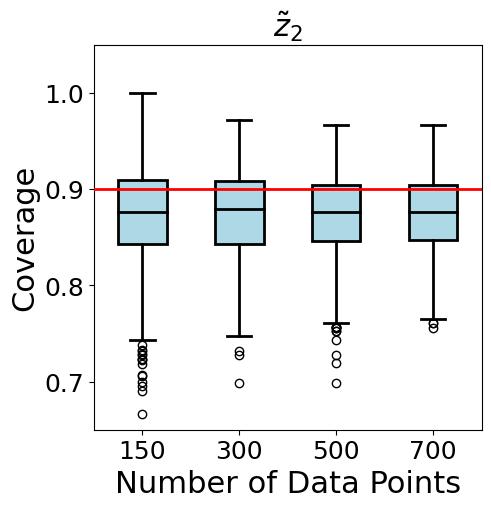

In [26]:
fig = plt.figure(figsize=(5, 5))
plt.boxplot(coverage_IRs, patch_artist=True, 
            medianprops=dict(color="black", linewidth=2),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  
plt.title(r"$\tilde{z}_2$", fontsize=22)
plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel('Coverage', fontsize=22)
plt.locator_params(axis='y', nbins=5)  
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)
plt.ylim([0.65, 1.05])
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=18)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=18)  # Correct way
plt.show()

In [27]:
random.seed(123)
np.random.seed(123)

N_values = [150,300,500,700]

COAD_averages = []
COAD_CIs = []
myerson_revenue_averages = []
myerson_revenue_CIs = []
second_price_averages = []
coverage_IRs = []
reserve_prices = []

for N in N_values:
    Table_his = Table_his_saveking
    Table_new = Table_new_saveking
    item = "saveking"
    num_runs = 1000
    indices= [1,8,9]
    COAD_average, COAD_CI, myerson_revenue_average, myerson_revenue_CI, second_price_average, _, coverage_IR, reserve_price = diff_N(Table_his, Table_new,N,item,num_runs, indices)
    COAD_averages.append(COAD_average)
    COAD_CIs.append(COAD_CI)
    myerson_revenue_averages.append(myerson_revenue_average)
    myerson_revenue_CIs.append(myerson_revenue_CI)
    second_price_averages.append(second_price_average)
    coverage_IRs.append(coverage_IR)
    reserve_prices.append(reserve_price)

In [28]:
COAD_CIs = [(x[1]-x[0])/2 for x in COAD_CIs]
myerson_revenue_CIs = [(x[1]-x[0])/2 for x in myerson_revenue_CIs]

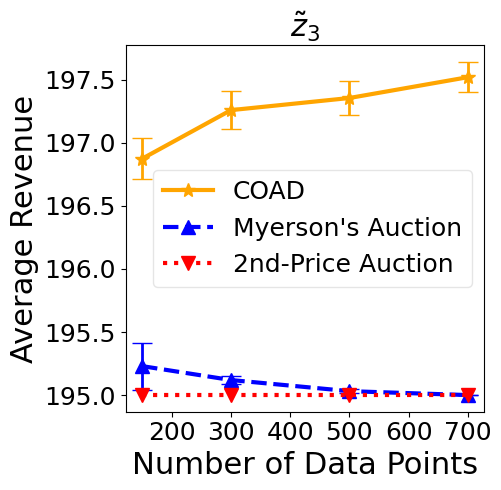

In [29]:
plt.figure(figsize=(5.1, 5))

plt.plot(N_values, COAD_averages, label="COAD", color='orange', linewidth=3, marker='*', markersize=10)
plt.plot(N_values, myerson_revenue_averages, label="Myerson's Auction", color='blue', linestyle='--', linewidth=3, marker='^', markersize=10)
plt.errorbar(N_values, COAD_averages, yerr=COAD_CIs, fmt='none', ecolor='orange', capsize=7, elinewidth=2)
plt.errorbar(N_values, myerson_revenue_averages, yerr=myerson_revenue_CIs, fmt='none', ecolor='blue', capsize=7, elinewidth=2)

plt.plot(N_values, second_price_averages, label="2nd-Price Auction", color='red', linestyle=':', linewidth=3, marker='v', markersize=10)

plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel("Average Revenue", fontsize=22)
plt.title(r"$\tilde{z}_3$", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks( fontsize=18)
plt.legend(fontsize=18,framealpha=0.5)
plt.grid(False)

plt.tight_layout()
plt.show()


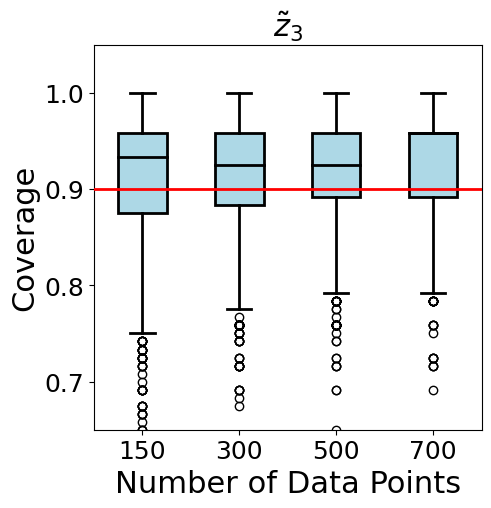

In [30]:
fig = plt.figure(figsize=(5, 5))
plt.boxplot(coverage_IRs, patch_artist=True, 
            medianprops=dict(color="black", linewidth=2,zorder=4),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  
plt.title(r"$\tilde{z}_3$", fontsize=22)
plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel('Coverage', fontsize=22)
plt.locator_params(axis='y', nbins=5)  
plt.ylim([0.65, 1.05])
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=18)
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=18)
plt.show()